# 0. Python warm ups ...

<function matplotlib.pyplot.show(*args, **kw)>

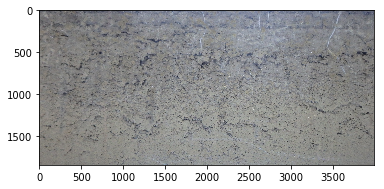

In [14]:
import matplotlib.pyplot as plt
anFile = 'figure/16_06_21_10E11c_P6210609_annotation.png'
imFile = 'figure/16_06_21_10E11c_P6210609_photo.png'
image = plt.imread(imFile)
plt.imshow(image)
plt.show

In [7]:
import numpy as np
print(type(image))
print(image.shape)
print(np.mean(image))

<class 'numpy.ndarray'>
(1842, 3991, 3)
0.5301275


# 1. Denoising

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
import scipy.ndimage as sp

## Denoising by filtering - from scratch

Make example image:

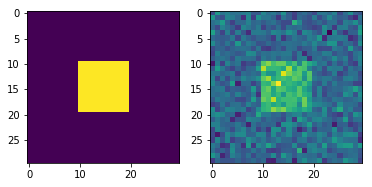

In [9]:
sz = 30
im = np.zeros((sz,sz))
im[10:20,10:20] = 1
noisy = im + np.random.normal(0, 0.3, (sz,sz))
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(im)
fig.add_subplot(1,2,2), plt.imshow(noisy);

Make a mean convolution filter:

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


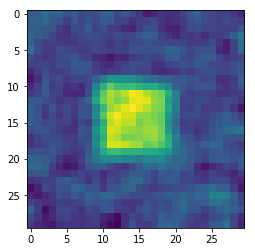

In [10]:
meanfilt = np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
print(meanfilt)
filtered = convolve(noisy, meanfilt)
plt.imshow(filtered);

Exercise: Mean filtering is most likely already implemented in a standard function. Find it (asking Professor Google) and try it ... 

In [12]:
#!pip install opencv-python

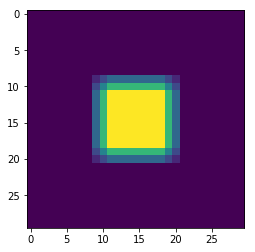

In [17]:
import cv2
blur = cv2.blur(im, (3,3))
plt.imshow(blur)

# 2. Feature Detection

## Edge Filter by convolution - from scratch

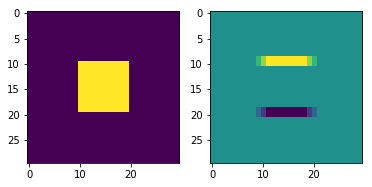

In [24]:
im = np.zeros((30,30))
im[10:20,10:20] = 1

filt = np.asarray([[1, 1, 1], 
                   [0, 0, 0], 
                   [-1, -1, -1]])
filtered = convolve(im, filt)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow(filtered);

Exercise: How do we then detect vertical edges?

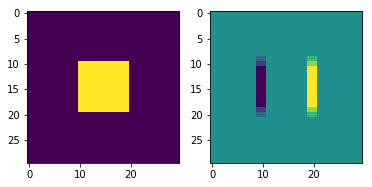

In [25]:
im = np.zeros((30,30))
im[10:20,10:20] = 1

filt = np.asarray([[-1, 0, 1], 
                   [-1, 0, 1], 
                   [-1, 0, 1]])
filtered = convolve(im, filt)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow(filtered);

In [29]:
filtered[:2]==im[:2]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])

为什么过滤后的图和原图相同数字，颜色不同呢？ 可能是数字最小的是深蓝色

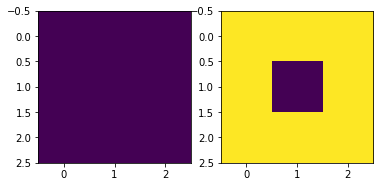

In [31]:
im = np.zeros((3,3))
im2 = np.zeros((3,3))
im2[1,1] = -5
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow(im2);

In [35]:
b = np.array([[2, 0, 0],
              [1, 0, 0],
              [0, 0, 0]])
k = np.array([[0,1,0],[0,1,0],[0,1,0]])
convolve(b, k)

array([[5, 0, 0],
       [3, 0, 0],
       [1, 0, 0]])

**The function's document is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html), but I still can't figure out how to use it!**

## Blob filter by convolution

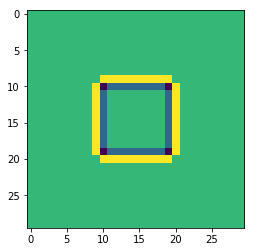

In [40]:
im = np.zeros((30,30))
im[10:20,10:20] = 1
filt = np.asarray([[0,  1, 0], 
                   [1, -4, 1], 
                   [0,  1, 0]])
filtered = convolve(im, filt)
plt.imshow(filtered);

This was not really what we wanted .... why?

## Gaussian Derivatives

In Math, we may locally approximate a function by the Taylor series expansion, including derivatives up a given order.
Images as not continuous, even less smooth. 
So we we use Gaussian derivatives: Ix = d(I) is performed as d(G * I) = I * d(G). 
Let's do this step by step ...

First, we use the gaussian_filter function that makes the Gaussian (derivative) filter and applies it to a given image: 

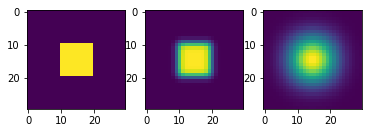

In [41]:
fig = plt.figure()
fig.add_subplot(1,3,1), plt.imshow(im)
fig.add_subplot(1,3,2), plt.imshow(sp.gaussian_filter(im, 1))
fig.add_subplot(1,3,3), plt.imshow(sp.gaussian_filter(im, 4));

The Gaussian filter blurs the image by convolution with a Gaussian kernel - at a given scale. Small scale gives narrow filter and limited blurring - large scale gives more blurring. We can use this blurring as an alternative to the denoising filter used above:

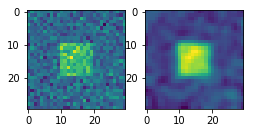

In [43]:
fig = plt.figure()
fig.add_subplot(1,3,1), plt.imshow(noisy)
fig.add_subplot(1,3,2), plt.imshow(sp.gaussian_filter(noisy, 1));

Next, if we convolve with a derivative of the Gaussian, we get a mathematically well-defined derivative. 

In [ ]:
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(sp.gaussian_filter(im, 1, (1,0)))
fig.add_subplot(1,2,2), plt.imshow(sp.gaussian_filter(im, 4, (0,1)));

By choosing the scale appropriately, we can look for features with small/large extent. 

Exercise: How do we find edges, invariant to the direction?

## Blob Detection, revisited

Above, the simple attempt at a blob filter failed. It would only have captured 1-pixel blobs. Using Gaussian derivatives, we can detect blobs as areas with high second order derivatives.

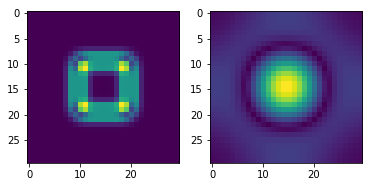

In [6]:
def Laplacian(im, scale):
    ixx = sp.gaussian_filter(im, scale, (2,0))
    iyy = sp.gaussian_filter(im, scale, (0,2))
    lap = ixx + iyy
    return np.abs(lap)

import scipy.ndimage as sp
import numpy as np
im = np.zeros((30,30))
im[10:20,10:20] = 1
lap1 = Laplacian(im, 1)
lap5 = Laplacian(im, 5)

fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(lap1)
fig.add_subplot(1,2,2), plt.imshow(lap5);

Where is the blob? 
Find the blob center from the locally maximal response in the filter ...

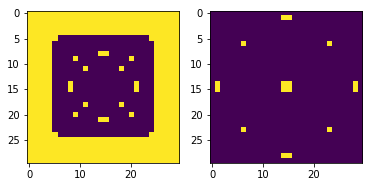

In [7]:
def immax(im):
    # Initialize "ismax" as a binary mask, true in all positions
    ismax = np.ones(im.shape)
    # Compare left/right/up/down and negate where neighbor is larger
    ismax[1: ,:] *= im[1: ,:] >= im[:-1,:] # comparing left
    ismax[:-1,:] *= im[:-1,:] >= im[1: ,:] # comparing right
    ismax[:, 1:] *= im[:, 1:] >= im[:,:-1] # comparing down
    ismax[:,:-1] *= im[:,:-1] >= im[:,1: ] # comparing up   
    return ismax

max1 = immax(lap1)
max5 = immax(lap5)

fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(max1)
fig.add_subplot(1,2,2), plt.imshow(max5);

What just happened here? How do we work with this output?

Bonus Exercise: The immax function looks really clumsy. Is there an elegant way to implement this function? Or at standard function doing it?

# 3. Most Prominent Objects

## Feature Strength

Above, we only used the feature detector response (the absolute of the Laplacian) to detect maximal feature locations. Can we also select only relevant blobs based on this "feature strength"?

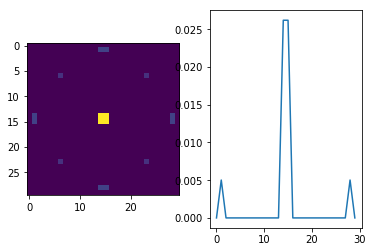

In [8]:
strength5 = lap5 * max5

fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(strength5)
fig.add_subplot(1,2,2), plt.plot(strength5[15,:]);

... so we can likely select only the "strong" blobs - more on this later.  

## Scale Normalization 

Above, we detected blobs at scales 1 and 5. Scale 1 was too small to meaningfully detect the blob, whereas scale 5 was suitable. We saw that the feature detector response could possibly indicate where the "strong" objects are. Let's continue along that track ...

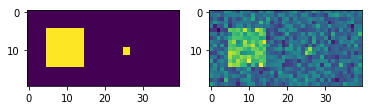

In [9]:
sz = (20,40)
im = np.zeros(sz)
im[5:15,5:15] = 1
im[10:12,25:27] = 1
noisy = im + np.random.normal(0, 0.3, sz)
fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(im)
fig.add_subplot(1,2,2), plt.imshow(noisy);

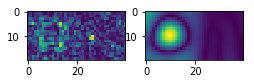

In [10]:
lap1 = Laplacian(noisy, 1)
lap5 = Laplacian(noisy, 5)
fig = plt.figure()
fig.add_subplot(1,3,1), plt.imshow(lap1)
fig.add_subplot(1,3,2), plt.imshow(lap5);

Exercise: Plot the responses in a line across the center of the map (through the center of the two squares). Where is the feature strength largest?

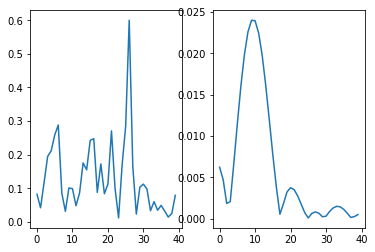

In [12]:
fig = plt.figure()
fig.add_subplot(1,2,1), plt.plot(lap1[10,:])
fig.add_subplot(1,2,2), plt.plot(lap5[10,:]);

By normalizing the derivatives by the scale, we get a scale-invariant measure of feature strength (e.g. Lindeberg 1983). This is done by multiplying be the factor - to the power of the order of differentiation:

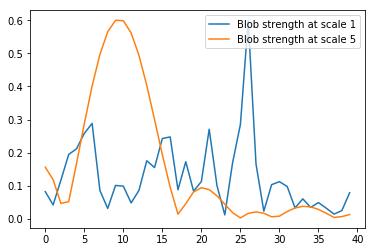

In [13]:
lap1 = Laplacian(noisy, 1) * 1**2
lap5 = Laplacian(noisy, 5) * 5**2
plt.plot(lap1[10,:])
plt.plot(lap5[10,:])
plt.legend(['Blob strength at scale 1','Blob strength at scale 5']);

## Scale Selection

If we know in advance how big objects we are looking for, we can design our methods to only detect the relevant objects. However, this may be hard to pre-determine. And there may be several objects of different sizes in the image. Generally, it would be more elegant to detect the optimal scale(s) automatically.

In [14]:
scaleCount = 10
sz = noisy.shape
strength = np.zeros((sz[0],sz[1],scaleCount))
for i in range(scaleCount):
    scale = i
    strength[:,:,i] = Laplacian(noisy, scale) * scale**2

Blob at (10, 9, 4) with strength 0.683330
Blob at (10,26, 1) with strength 0.599757
Blob at (12, 6, 2) with strength 0.534552


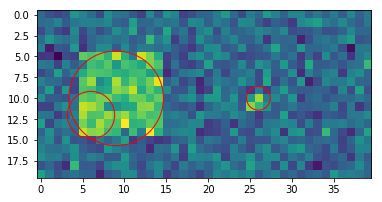

In [15]:
from skimage.feature import peak_local_max

findBlobs = 3
blobs = peak_local_max(strength, num_peaks=findBlobs)
plt.imshow(noisy)
ax = plt.gca()
for b in range(findBlobs):
    print('Blob at (%2d,%2d,%2d) with strength %f' % (blobs[b,0], blobs[b,1], blobs[b,2], strength[blobs[b,0], blobs[b,1], blobs[b,2]]))
    ax.add_artist(plt.Circle((blobs[b,1], blobs[b,0]), np.sqrt(2)*blobs[b,2], color='r', fill=False))

(<matplotlib.axes._subplots.AxesSubplot at 0x26a0b36cbe0>,
 <matplotlib.image.AxesImage at 0x26a0b3c14a8>)

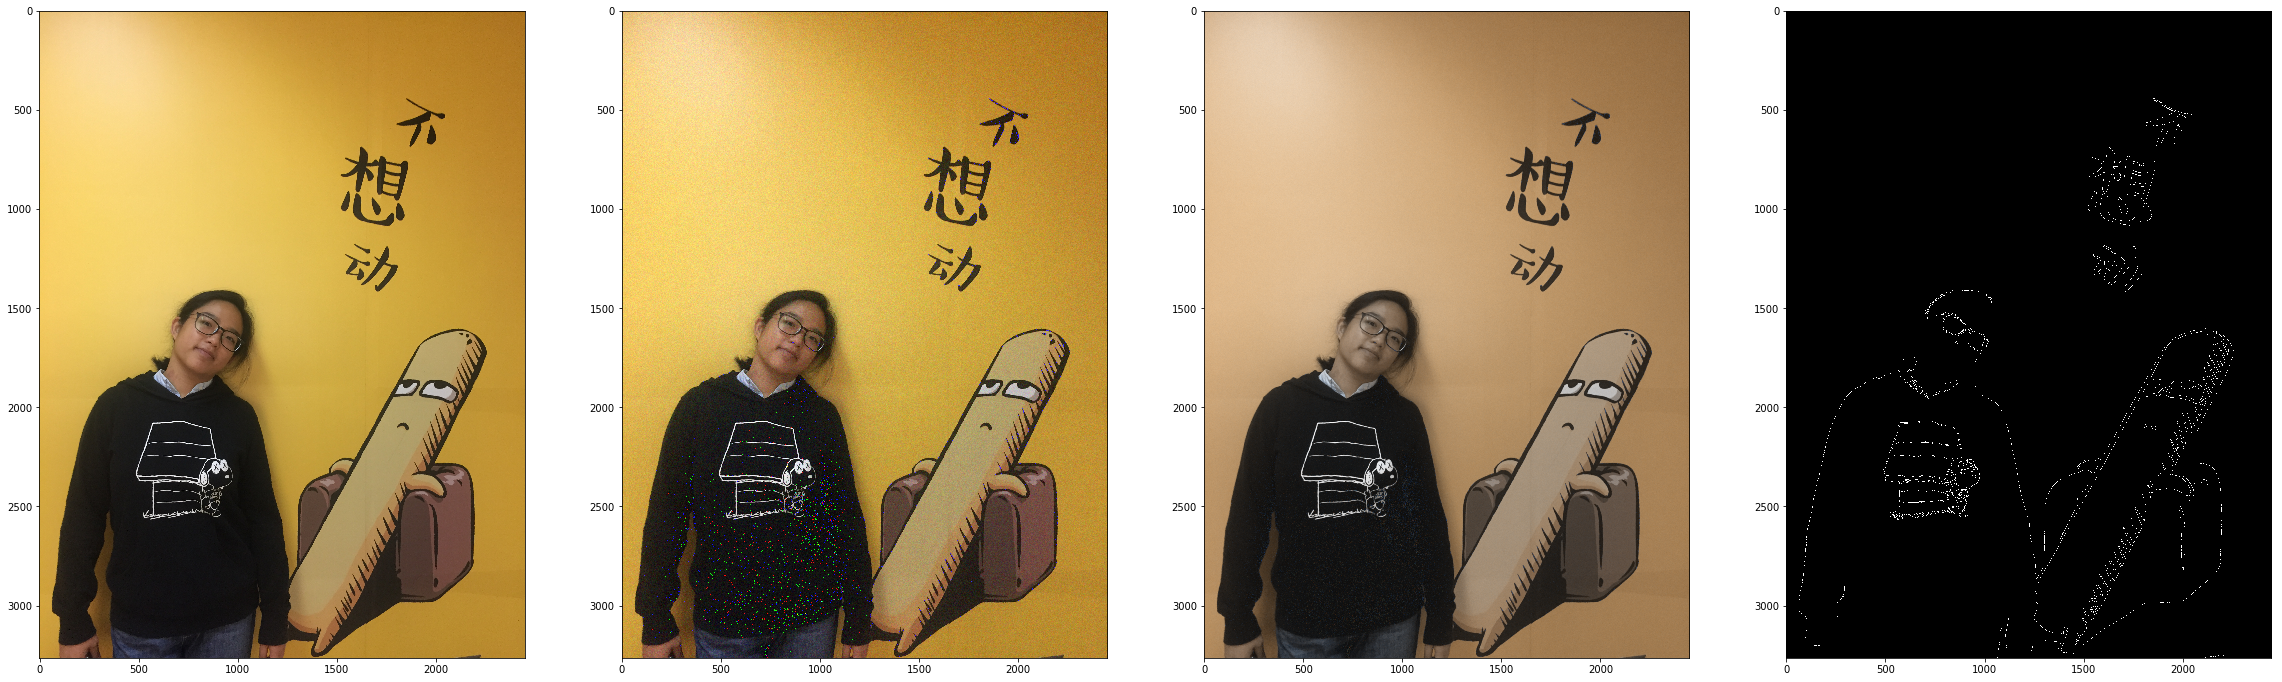

In [71]:
#test 
## first to read the figure 
import matplotlib.pyplot as plt
imFile = 'figure/test.JPG'
image = plt.imread(imFile)

## second to rotate the figure
import scipy as sci 
image2 = sci.ndimage.rotate(image, -90)

## third to add noise / here is wrong for add the signal is not integer
# noisy = image2 + np.random.normal(0, 0.3, (image2.shape[0],image2.shape[1], image2.shape[2]))
def add_gasuss_noise(image, mean=0, var=0.001):
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    return out
noisy = add_gasuss_noise(image2)
## forth to filter the figure use gaussian 
#plt.imshow(sp.gaussian_filter(image2, 1))

## fifth find the eage 
import cv2
edges = cv2.Canny(image2, 50, 400)
#plt.imshow(edges, cmap = "gray")

fig = plt.figure(figsize= (40, 20))
fig.add_subplot(1,4,1), plt.imshow(image2)
fig.add_subplot(1,4,2), plt.imshow(noisy)
fig.add_subplot(1,4,3), plt.imshow(sp.gaussian_filter(noisy, 1))
fig.add_subplot(1,4,4), plt.imshow(edges, cmap = "gray")


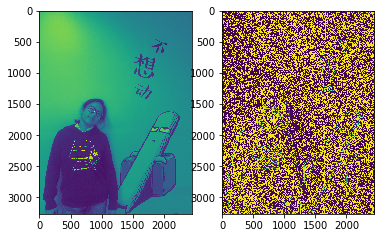

In [69]:
gray_image = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
filt = np.asarray([[1,  0, -1], 
                   [1,  0, -1], 
                   [1,  0, -1]])
filtered = convolve(gray_image, filt)

fig = plt.figure()
fig.add_subplot(1,2,1), plt.imshow(gray_image)
fig.add_subplot(1,2,2), plt.imshow(filtered);